In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision

from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb
from catalyst.data.sampler import BalanceClassSampler
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'inception_resnet_v2',
    'img_size': 260,
    'epochs': 200,
    'train_bs':128,
    'valid_bs':32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'num_workers': 8,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'patience' : 5,
    'device': 'cuda:0',
    'freezing': False,
    'model_path': './models'
}

In [22]:
project_name = 'carbon_reduction_inception_resnet_v2_1040'
user = 'hojunking'
run_name = 'carbon_reduction_inception_resnet_v2_1040'

In [3]:
main_path = '../Data/carbon_reduction/'
label_list = ["10kwalking","public_vehicle",'stair','pet','outlet','else', 'can', 'box', 'milk', 'cup']

total_train_img_paths = []
total_train_img_labels = []
total_test_img_paths = []
total_test_img_labels = []

for label in label_list: ## 각 레이블 돌기
  print(f'label: {label}')
  img_paths = [] 
  img_labels = []

  # default ratio
  train_ratio = 1000
  test_ratio = 400

  dir_path = main_path + label ## 레이블 폴더 경로
  count = 0
  for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
    
    for img in filenames: ## 각 파일 경로, 레이블 저장
      count +=1
      if count > train_ratio + test_ratio:
        break
      
      img_paths.append(folder+'/'+img)
      img_labels.append(label)

  print(f'img_paths len : {len(img_paths)}\n')

  if label == '10kwalking': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
    train_ratio = 1000
    test_ratio = 400
  elif label == 'public_vehicle': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
    train_ratio = 1000
    test_ratio = 400

  total_train_img_paths.extend(img_paths[:train_ratio])
  total_train_img_labels.extend(img_labels[:train_ratio])
  
  total_test_img_paths.extend(img_paths[-test_ratio:])
  total_test_img_labels.extend(img_labels[-test_ratio:])

print('Train_Images: ',len(total_train_img_paths))
print("Train_Images_labels:", len(total_train_img_labels))
print('Test_Images: ',len(total_test_img_paths))
print("Test_Images_labels:", len(total_test_img_labels))

label: 10kwalking
img_paths len : 1400

label: public_vehicle
img_paths len : 1243

label: stair
img_paths len : 1400

label: pet
img_paths len : 1400

label: outlet
img_paths len : 1400

label: else
img_paths len : 1400

label: can
img_paths len : 1400

label: box
img_paths len : 1400

label: milk
img_paths len : 1400

label: cup
img_paths len : 1068

Train_Images:  10000
Train_Images_labels: 10000
Test_Images:  4000
Test_Images_labels: 4000


In [4]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(total_train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = total_train_img_labels
train = trn_df
train

,image_id,dir,label
0,캐시워크 만보_461.jpg,../Data/carbon_reduction/10kwalking,10kwalking
1,캐시워크 만보_017.jpg,../Data/carbon_reduction/10kwalking,10kwalking
2,만보인증_171.jpg,../Data/carbon_reduction/10kwalking,10kwalking
3,나이키 만보_231.jpg,../Data/carbon_reduction/10kwalking,10kwalking
4,삼성헬스 만보_451.jpg,../Data/carbon_reduction/10kwalking,10kwalking
...,...,...,...
9995,양치컵_245.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup
9996,양치컵_231.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup
9997,양치컵_176.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup
9998,양치컵_234.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup


In [5]:
# Label Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)

In [9]:
train

,image_id,dir,label
0,캐시워크 만보_461.jpg,../Data/carbon_reduction/10kwalking,0
1,캐시워크 만보_017.jpg,../Data/carbon_reduction/10kwalking,0
2,만보인증_171.jpg,../Data/carbon_reduction/10kwalking,0
3,나이키 만보_231.jpg,../Data/carbon_reduction/10kwalking,0
4,삼성헬스 만보_451.jpg,../Data/carbon_reduction/10kwalking,0
...,...,...,...
9995,양치컵_245.jpg,../Data/carbon_reduction/cup/양치컵_네이버,3
9996,양치컵_231.jpg,../Data/carbon_reduction/cup/양치컵_네이버,3
9997,양치컵_176.jpg,../Data/carbon_reduction/cup/양치컵_네이버,3
9998,양치컵_234.jpg,../Data/carbon_reduction/cup/양치컵_네이버,3


In [10]:
model =timm.create_model(CFG['model'], pretrained=True, num_classes=10)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [12]:
def get_img(path, train_arg=False, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    if train_arg:
        dimg = cv2.fastNlMeansDenoisingColored(im_rgb, None, 10,10,7,21)
        return dimg
    else:
        return im_rgb

In [13]:
transform_train = A.Compose(
    [
        A.Resize(height = CFG['img_size']+100, width = CFG['img_size']+100),
        A.CenterCrop(always_apply=True, p=0.7, height=CFG['img_size'], width=CFG['img_size']),
        A.RandomBrightnessContrast(always_apply=True, p=0.8, brightness_limit=(0.00, 0.00), contrast_limit=(0.2, 0.2), brightness_by_max=False),
        A.SafeRotate(always_apply=True, p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
        A.HorizontalFlip(always_apply=False, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_test = A.Compose(
    [
        A.Resize(height = CFG['img_size'], width = CFG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

In [14]:
class ColonDataset(Dataset):
    def __init__(self, df, data_root, train_arg=False,
                 transform=None,
                 output_label=True
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.train_arg = train_arg
        self.transform = transform
        self.data_root = data_root
        self.output_label = output_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
        
        img  = get_img("{}/{}".format(self.data_root[index], self.df.loc[index]['image_id']), train_arg=self.train_arg)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
        
                
        if self.output_label == True:
            return img, target
        else:
            return img

In [15]:
class ForcepImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class=10, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
        # n_features = self.model.classifier.in_features
        # self.model.classifier = nn.Linear(n_features, n_class)
    def freezing(self, freeze=False):
        if freeze:
            
            cnt = 0
            for name, param in model.named_parameters():
                if 'classif' in name:
                    #print('classif passed')
                    pass
                elif 'fc' in name:
                    #print('fc passed')
                    pass
                else :
                    #print('freezing')
                    param.requires_grad = False    
        
    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = ColonDataset(train_,
                            train_data_root,
                            transform=transform_train,
                            output_label=True)
    valid_ds = ColonDataset(valid_,
                            valid_data_root,
                            transform=transform_train,
                            output_label=True)
    

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=False,        
        num_workers=CFG['num_workers'],
        sampler=DistributedSampler(train_ds)
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [17]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        with autocast():
            image_preds = model(imgs)   #output = model(input)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss.detach()
            
            scaler.scale(loss).backward()
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
            
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    epoch_f1 = f1_score(image_targets_all, 
                        image_preds_all, 
                        average='macro')
    
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
    
    return image_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, 
                        image_preds_all, 
                        average='macro')
    
    acc = (image_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return image_preds_all, acc, val_loss, matrix, epoch_f1

In [18]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [19]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [20]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1' #본인이 사용하고 싶은 GPU 넘버를 써주면 됨
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '43097'         # 좀 큰 숫자로 맞추면 됨 작은 숫자는 에러발생!

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# init!
torch.distributed.init_process_group(backend='nccl', init_method="env://", rank =0, world_size=1)  # rank should be 0 ~ world_size-1


In [23]:
model_dir = '{}'.format(CFG['model'])
train_dir = train.dir.values

if __name__ == '__main__':
     # for training only, need nightly build pytorch
    wandb.init(project=project_name, entity=user)
    
#     wandb.login()
#     wandb.init(project="3class classification")
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    
    seed_everything(CFG['seed'])
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    best_fold = 0
    model_name = CFG['model']
    print(f'Model: {model_name}')
    for fold, (trn_idx, val_idx) in enumerate(folds):
    
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        device = torch.device(CFG['device'])
        
        model = ForcepImgClassifier(CFG['model'], train.label.nunique(), pretrained=True)
        model.freezing(freeze = CFG['freezing'])

        for name, param in model.named_parameters():
            if CFG['freezing'] == True and param.requires_grad:
                print(f'Freezing process: Not freezed : {name}')
        if CFG['freezing'] == False:
            print('All training process')
        
        
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        model.to(device)
        model = DDP(model)

        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=25)

        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)

        wandb.watch(model, loss_tr, log='all')

        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []
        best_f1 =0.0
        
        start = time.time()
        for epoch in range(CFG['epochs']):
            print(f'Fold: {fold}')
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))
            
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                        optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                        val_loader, device, scheduler=None, schd_loss_update=False)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
                
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)
            
            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)
            
            
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                torch.save(model.state_dict(), (model_dir+'/{}_{}').format(CFG['model'],fold))
                
            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break
    
        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        
        print(f'fold: {fold}, Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        
        print(f'fold: {fold}, Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('---------------------------------------------------------')
        
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'best_fold : {best_fold}\n Top fold : {top_fold}')

    del model, optimizer, train_loader, val_loader, scaler
    torch.cuda.empty_cache()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: inception_resnet_v2
Training start with fold: 0 epoch: 200 

All training process
Fold: 0
Epoch 0/199


  0%|                                                    | 0/63 [00:00<?, ?it/s]Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
Premature end of JPEG file
  0%|                                                    | 0/63 [00:00<?, ?it/s]Premature end of JPEG file
Premature end of JPEG file
epoch 0 loss: 0.2460: 100%|█████████████████████| 63/63 [00:17<00:00,  3.67it/s]


Fold: 0
Epoch 1/199


  0%|                                                    | 0/63 [00:00<?, ?it/s]Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
Premature end of JPEG file
epoch 1 loss: 0.1394: 100%|█████████████████████| 63/63 [00:16<00:00,  3.86it/s]


Fold: 0
Epoch 2/199


epoch 2 loss: 0.1488: 100%|█████████████████████| 63/63 [00:16<00:00,  3.83it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9606238274371794
Fold: 0
Epoch 3/199



epoch 3 loss: 0.1411: 100%|█████████████████████| 63/63 [00:16<00:00,  3.89it/s]

EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9606238274371794
Fold: 0
Epoch 4/199



  0%|                                                    | 0/63 [00:00<?, ?it/s]Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
Premature end of JPEG file
epoch 4 loss: 0.1619: 100%|█████████████████████| 63/63 [00:16<00:00,  3.82it/s]

EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9606238274371794
Fold: 0
Epoch 5/199



epoch 5 loss: 0.1487: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]


Fold: 0
Epoch 6/199


  0%|                                                    | 0/63 [00:00<?, ?it/s]Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
Premature end of JPEG file
epoch 6 loss: 0.1454: 100%|█████████████████████| 63/63 [00:16<00:00,  3.82it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9618292392456531
Fold: 0
Epoch 7/199



epoch 7 loss: 0.1392: 100%|█████████████████████| 63/63 [00:16<00:00,  3.73it/s]

EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9618292392456531
Fold: 0
Epoch 8/199



epoch 8 loss: 0.1523: 100%|█████████████████████| 63/63 [00:16<00:00,  3.87it/s]


Fold: 0
Epoch 9/199


epoch 9 loss: 0.1545: 100%|█████████████████████| 63/63 [00:16<00:00,  3.86it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9629007130310328
Fold: 0
Epoch 10/199



epoch 10 loss: 0.1820: 100%|████████████████████| 63/63 [00:16<00:00,  3.85it/s]

EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9629007130310328
Fold: 0
Epoch 11/199



epoch 11 loss: 0.1796: 100%|████████████████████| 63/63 [00:16<00:00,  3.81it/s]

EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9629007130310328
Fold: 0
Epoch 12/199



epoch 12 loss: 0.1790: 100%|████████████████████| 63/63 [00:16<00:00,  3.88it/s]

EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9629007130310328
Fold: 0
Epoch 13/199



epoch 13 loss: 0.1779: 100%|████████████████████| 63/63 [00:16<00:00,  3.88it/s]


EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9629007130310328
stop called
time : 0:15:41
fold: 0, Best Epoch : 8/ 14
fold: 0, Best Train Marco F1 : 0.99476
[[799   0   0   0   0   0   0   0   0   1]
 [  0 800   0   0   0   0   0   0   0   0]
 [  0   0 798   0   2   0   0   0   0   0]
 [  0   0   0 796   0   0   0   0   0   4]
 [  0   0   1   0 796   0   0   3   0   0]
 [  1   0   0   0   1 793   0   0   1   4]
 [  0   0   0   0   0   0 800   0   0   0]
 [  0   0   2   0   2   0   0 796   0   0]
 [  0   0   0   0   0   0   0   0 781  19]
 [  0   0   0   0   0   0   0   0   1 799]]
fold: 0, Best Valid Marco F1 : 0.96290
[[197   0   0   1   0   1   0   0   0   1]
 [  0 196   0   0   3   1   0   0   0   0]
 [  0   0 188   4   1   3   0   3   1   0]
 [  0   0   1 196   0   1   0   1   0   1]
 [  1   5   3   2 179   5   1   2   0   2]
 [  0   0   0   2   0 197   0   0   0   1]
 [  0   0   0   0   2   1 197   0   0   0]
 [  0   1   4   1   7   0   0 187   0   0]
 [  0   0   0  

epoch 0 loss: 0.2500: 100%|█████████████████████| 63/63 [00:16<00:00,  3.86it/s]


Fold: 1
Epoch 1/199


epoch 1 loss: 0.1423: 100%|█████████████████████| 63/63 [00:16<00:00,  3.79it/s]


Fold: 1
Epoch 2/199


epoch 2 loss: 0.1542: 100%|█████████████████████| 63/63 [00:16<00:00,  3.83it/s]


Fold: 1
Epoch 3/199


epoch 3 loss: 0.1486: 100%|█████████████████████| 63/63 [00:16<00:00,  3.89it/s]


Fold: 1
Epoch 4/199


epoch 4 loss: 0.1380: 100%|█████████████████████| 63/63 [00:16<00:00,  3.82it/s]


Fold: 1
Epoch 5/199


epoch 5 loss: 0.1721: 100%|█████████████████████| 63/63 [00:16<00:00,  3.87it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9619364088910153
Fold: 1
Epoch 6/199



epoch 6 loss: 0.1603: 100%|█████████████████████| 63/63 [00:16<00:00,  3.85it/s]

EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9619364088910153
Fold: 1
Epoch 7/199



epoch 7 loss: 0.1435: 100%|█████████████████████| 63/63 [00:16<00:00,  3.74it/s]

EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9619364088910153
Fold: 1
Epoch 8/199



epoch 8 loss: 0.1483: 100%|█████████████████████| 63/63 [00:16<00:00,  3.81it/s]


Fold: 1
Epoch 9/199


epoch 9 loss: 0.1689: 100%|█████████████████████| 63/63 [00:16<00:00,  3.86it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.962347055571442
Fold: 1
Epoch 10/199



epoch 10 loss: 0.1368: 100%|████████████████████| 63/63 [00:16<00:00,  3.87it/s]


Fold: 1
Epoch 11/199


epoch 11 loss: 0.1520: 100%|████████████████████| 63/63 [00:16<00:00,  3.88it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9700659515166781
Fold: 1
Epoch 12/199



epoch 12 loss: 0.1613: 100%|████████████████████| 63/63 [00:16<00:00,  3.81it/s]

EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9700659515166781
Fold: 1
Epoch 13/199



epoch 13 loss: 0.1802: 100%|████████████████████| 63/63 [00:16<00:00,  3.88it/s]

EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9700659515166781
Fold: 1
Epoch 14/199



epoch 14 loss: 0.1830: 100%|████████████████████| 63/63 [00:16<00:00,  3.87it/s]

EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9700659515166781
Fold: 1
Epoch 15/199



epoch 15 loss: 0.1467: 100%|████████████████████| 63/63 [00:16<00:00,  3.73it/s]


EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9700659515166781
stop called
time : 0:17:49
fold: 1, Best Epoch : 10/ 16
fold: 1, Best Train Marco F1 : 0.99289
[[799   0   0   0   0   0   0   0   0   1]
 [  0 796   0   0   3   0   0   1   0   0]
 [  0   0 797   0   3   0   0   0   0   0]
 [  0   0   0 794   0   2   0   0   2   2]
 [  0   4   1   1 794   0   0   0   0   0]
 [  0   0   0   1   0 794   0   0   4   1]
 [  0   0   0   0   1   0 799   0   0   0]
 [  0   0   0   0   0   0   0 800   0   0]
 [  0   0   0   0   0   0   0   0 782  18]
 [  0   0   0   0   0   0   0   0  12 788]]
fold: 1, Best Valid Marco F1 : 0.97007
[[198   0   0   0   0   1   0   0   0   1]
 [  0 191   1   0   5   2   1   0   0   0]
 [  1   0 191   3   3   1   0   1   0   0]
 [  0   0   0 196   1   2   0   0   0   1]
 [  0   0   3   2 188   3   1   2   0   1]
 [  0   0   1   9   0 188   0   0   1   1]
 [  0   0   1   0   1   1 197   0   0   0]
 [  0   0   1   1   3   1   0 194   0   0]
 [  0   0   0 

epoch 0 loss: 0.2523: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]


Fold: 2
Epoch 1/199


epoch 1 loss: 0.1513: 100%|█████████████████████| 63/63 [00:16<00:00,  3.87it/s]


Fold: 2
Epoch 2/199


epoch 2 loss: 0.1388: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]


Fold: 2
Epoch 3/199


epoch 3 loss: 0.1521: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]


Fold: 2
Epoch 4/199


epoch 4 loss: 0.1431: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]


Fold: 2
Epoch 5/199


epoch 5 loss: 0.1628: 100%|█████████████████████| 63/63 [00:16<00:00,  3.85it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.963399428018349
Fold: 2
Epoch 6/199



epoch 6 loss: 0.1599: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]

EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.963399428018349
Fold: 2
Epoch 7/199



epoch 7 loss: 0.1736: 100%|█████████████████████| 63/63 [00:16<00:00,  3.76it/s]

EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.963399428018349
Fold: 2
Epoch 8/199



epoch 8 loss: 0.1618: 100%|█████████████████████| 63/63 [00:16<00:00,  3.85it/s]

EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.963399428018349
Fold: 2
Epoch 9/199



epoch 9 loss: 0.1805: 100%|█████████████████████| 63/63 [00:16<00:00,  3.85it/s]


EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.963399428018349
stop called
time : 0:11:05
fold: 2, Best Epoch : 4/ 10
fold: 2, Best Train Marco F1 : 0.99041
[[794   0   0   0   4   0   0   0   0   2]
 [  0 797   0   0   1   0   1   0   1   0]
 [  0   0 791   1   3   1   0   4   0   0]
 [  1   0   2 791   0   0   0   0   0   6]
 [  3   0   1   0 793   0   1   0   0   2]
 [  0   0   0   1   0 793   0   0   0   6]
 [  0   0   0   0   1   0 799   0   0   0]
 [  0   0   5   0   3   0   0 792   0   0]
 [  0   0   0   0   0   0   0   0 777  23]
 [  0   0   0   0   1   0   0   0   3 796]]
fold: 2, Best Valid Marco F1 : 0.96340
[[198   0   0   0   0   1   0   0   0   1]
 [  0 193   0   0   5   2   0   0   0   0]
 [  0   0 189   0   2   3   2   4   0   0]
 [  1   0   2 195   1   1   0   0   0   0]
 [  5   2   3   3 177   1   5   2   1   1]
 [  0   1   1   1   3 194   0   0   0   0]
 [  0   0   0   0   3   0 197   0   0   0]
 [  0   0   1   0   3   2   0 194   0   0]
 [  0   0   0   

epoch 0 loss: 0.2933: 100%|█████████████████████| 63/63 [00:16<00:00,  3.89it/s]


Fold: 3
Epoch 1/199


epoch 1 loss: 0.1611: 100%|█████████████████████| 63/63 [00:16<00:00,  3.86it/s]


Fold: 3
Epoch 2/199


epoch 2 loss: 0.1474: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]


Fold: 3
Epoch 3/199


epoch 3 loss: 0.1764: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9575783080255595
Fold: 3
Epoch 4/199



epoch 4 loss: 0.1932: 100%|█████████████████████| 63/63 [00:16<00:00,  3.90it/s]

EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9575783080255595
Fold: 3
Epoch 5/199



epoch 5 loss: 0.1824: 100%|█████████████████████| 63/63 [00:16<00:00,  3.86it/s]

EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9575783080255595
Fold: 3
Epoch 6/199



epoch 6 loss: 0.1713: 100%|█████████████████████| 63/63 [00:16<00:00,  3.84it/s]


Fold: 3
Epoch 7/199


epoch 7 loss: 0.1758: 100%|█████████████████████| 63/63 [00:16<00:00,  3.75it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.957661049588947
Fold: 3
Epoch 8/199



epoch 8 loss: 0.2413: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]

EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.957661049588947
Fold: 3
Epoch 9/199



epoch 9 loss: 0.1818: 100%|█████████████████████| 63/63 [00:16<00:00,  3.86it/s]

EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.957661049588947
Fold: 3
Epoch 10/199



epoch 10 loss: 0.1861: 100%|████████████████████| 63/63 [00:16<00:00,  3.85it/s]

EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.957661049588947
Fold: 3
Epoch 11/199



epoch 11 loss: 0.2046: 100%|████████████████████| 63/63 [00:16<00:00,  3.88it/s]


EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.957661049588947
stop called
time : 0:13:14
fold: 3, Best Epoch : 6/ 12
fold: 3, Best Train Marco F1 : 0.99251
[[798   0   0   0   0   0   0   0   0   2]
 [  0 795   0   0   4   0   1   0   0   0]
 [  0   0 799   1   0   0   0   0   0   0]
 [  1   0   0 793   2   1   0   0   0   3]
 [  0   2   1   1 794   0   2   0   0   0]
 [  1   0   0   2   0 794   0   0   0   3]
 [  0   2   0   0   0   0 798   0   0   0]
 [  0   0   1   0   2   0   0 797   0   0]
 [  0   0   0   0   0   0   0   0 778  22]
 [  0   0   0   0   0   0   0   0   6 794]]
fold: 3, Best Valid Marco F1 : 0.95766
[[196   0   0   2   0   2   0   0   0   0]
 [  0 193   0   0   7   0   0   0   0   0]
 [  0   1 186   2   4   3   0   4   0   0]
 [  0   0   0 194   1   3   0   0   0   2]
 [  0   3   3   5 185   1   1   2   0   0]
 [  0   3   0   5   3 184   0   1   1   3]
 [  0   0   0   1   3   0 196   0   0   0]
 [  0   0   5   0   5   0   0 189   0   1]
 [  0   0   0   

epoch 0 loss: 2.3022:  27%|█████▋               | 17/63 [00:15<00:34,  1.35it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 0 loss: 0.2835: 100%|█████████████████████| 63/63 [00:16<00:00,  3.88it/s]


Fold: 4
Epoch 1/199


epoch 1 loss: 0.2312:  27%|█████▋               | 17/63 [00:14<00:34,  1.34it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 1 loss: 0.1622: 100%|█████████████████████| 63/63 [00:16<00:00,  3.84it/s]


Fold: 4
Epoch 2/199


epoch 2 loss: 0.1115:  27%|█████▋               | 17/63 [00:14<00:34,  1.35it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 2 loss: 0.1651: 100%|█████████████████████| 63/63 [00:16<00:00,  3.85it/s]


Fold: 4
Epoch 3/199


epoch 3 loss: 0.0723:  27%|█████▋               | 17/63 [00:14<00:34,  1.35it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 3 loss: 0.1716: 100%|█████████████████████| 63/63 [00:16<00:00,  3.84it/s]


Fold: 4
Epoch 4/199


epoch 4 loss: 0.0224:  27%|█████▋               | 17/63 [00:14<00:34,  1.34it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 4 loss: 0.1656: 100%|█████████████████████| 63/63 [00:16<00:00,  3.83it/s]


Fold: 4
Epoch 5/199


epoch 5 loss: 0.0288:  27%|█████▋               | 17/63 [00:14<00:34,  1.35it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 5 loss: 0.1788: 100%|█████████████████████| 63/63 [00:16<00:00,  3.87it/s]

EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9607121534148533
Fold: 4
Epoch 6/199



epoch 6 loss: 0.0369:  27%|█████▋               | 17/63 [00:15<00:34,  1.34it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 6 loss: 0.1810: 100%|█████████████████████| 63/63 [00:16<00:00,  3.87it/s]

EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9607121534148533
Fold: 4
Epoch 7/199



epoch 7 loss: 0.0184:  27%|█████▋               | 17/63 [00:14<00:34,  1.34it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 7 loss: 0.1826: 100%|█████████████████████| 63/63 [00:16<00:00,  3.71it/s]

EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9607121534148533
Fold: 4
Epoch 8/199



epoch 8 loss: 0.0151:  27%|█████▋               | 17/63 [00:15<00:34,  1.35it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 8 loss: 0.1760: 100%|█████████████████████| 63/63 [00:16<00:00,  3.87it/s]

EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9607121534148533
Fold: 4
Epoch 9/199



epoch 9 loss: 0.0099:  27%|█████▋               | 17/63 [00:14<00:34,  1.34it/s]Premature end of JPEG file
Corrupt JPEG data: 111 extraneous bytes before marker 0xd9
epoch 9 loss: 0.1708: 100%|█████████████████████| 63/63 [00:16<00:00,  3.87it/s]


EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9607121534148533
stop called
time : 0:11:05
fold: 4, Best Epoch : 4/ 10
fold: 4, Best Train Marco F1 : 0.99177
[[798   0   0   0   0   0   0   0   0   2]
 [  0 797   0   0   3   0   0   0   0   0]
 [  0   0 794   0   2   2   0   2   0   0]
 [  0   0   0 792   1   2   1   0   0   4]
 [  0   3   1   1 793   0   0   2   0   0]
 [  0   0   0   2   1 792   0   0   0   5]
 [  0   0   0   1   1   0 798   0   0   0]
 [  0   0   1   0   3   0   0 796   0   0]
 [  0   0   0   0   0   0   0   0 777  23]
 [  0   0   0   0   1   0   0   0   2 797]]
fold: 4, Best Valid Marco F1 : 0.96071
[[199   0   0   0   1   0   0   0   0   0]
 [  0 184   0   0  15   0   1   0   0   0]
 [  0   0 185   2  10   3   0   0   0   0]
 [  0   0   1 193   0   3   0   2   0   1]
 [  1   1   4   1 183   1   3   3   1   2]
 [  0   0   1   2   2 192   1   0   1   1]
 [  0   0   0   0   0   0 200   0   0   0]
 [  0   0   2   0   4   0   0 194   0   0]
 [  0   0   0  

In [9]:
dist.destroy_process_group()

In [6]:
## Pandas Test 데이터프레임 만들기
tst_df = pd.DataFrame(total_test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = total_test_img_labels
test = tst_df
test

,image_id,dir,label
0,토스 만보_459.jpg,../Data/carbon_reduction/10kwalking,10kwalking
1,캐시워크 만보_262.jpg,../Data/carbon_reduction/10kwalking,10kwalking
2,아이폰 걸음수_192.jpg,../Data/carbon_reduction/10kwalking,10kwalking
3,삼성헬스 만보_352.jpg,../Data/carbon_reduction/10kwalking,10kwalking
4,아이폰 걸음수_408.jpg,../Data/carbon_reduction/10kwalking,10kwalking
...,...,...,...
3995,양치컵_310.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup
3996,양치컵_256.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup
3997,양치컵_250.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup
3998,양치컵_114.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup


In [17]:
test['label'] = le.fit_transform(test['label'].values)

In [8]:
model_name = 'inception_resnet_v2'
model_dir = model_name + '/inception_resnet_v2_1'
%run inference.ipynb

100%|███████████████████████████████████████████| 32/32 [00:36<00:00,  1.13s/it]


accuracy: 0.8850
f1_score: 0.8938


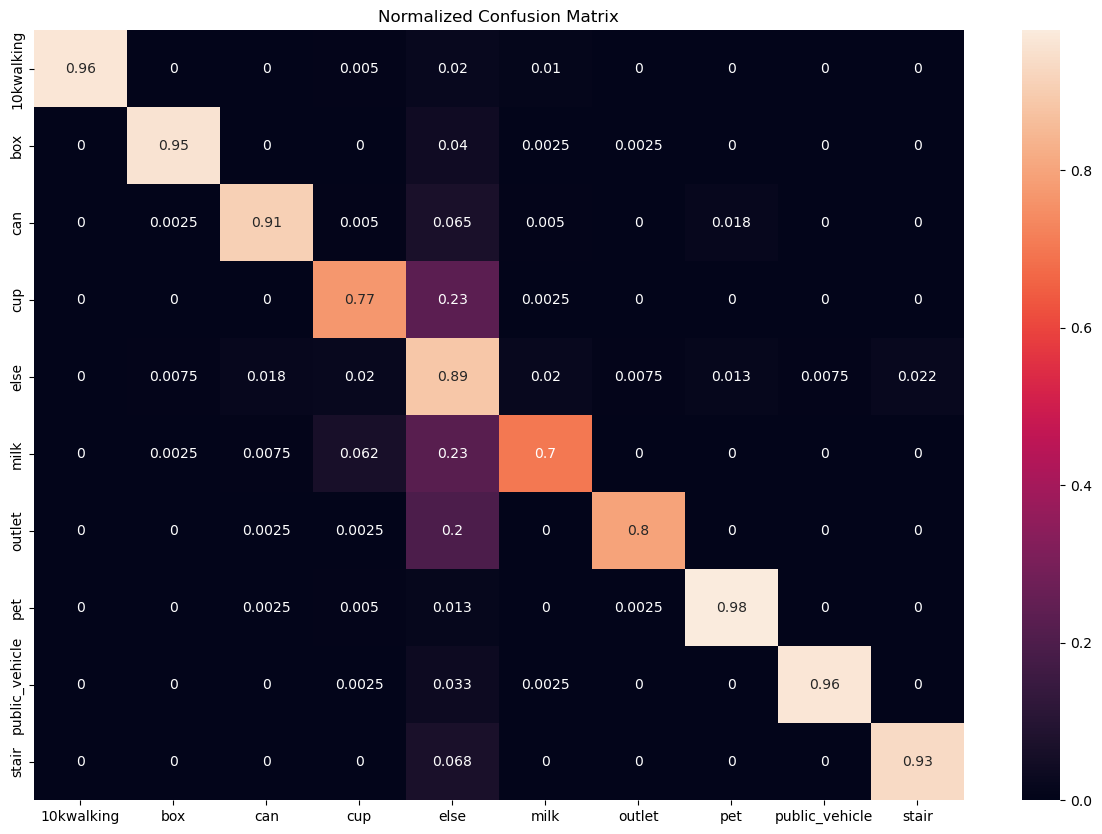

In [19]:
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')
import seaborn as sns

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
test['label'] = le.inverse_transform(test['label'].values)
plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')

In [14]:
test['label'] = le.inverse_transform(test['label'].values)

In [15]:
test

,image_id,dir,label,pred,confidence score
0,토스 만보_459.jpg,../Data/carbon_reduction/10kwalking,10kwalking,0,0.999351
1,캐시워크 만보_262.jpg,../Data/carbon_reduction/10kwalking,10kwalking,0,0.999483
2,아이폰 걸음수_192.jpg,../Data/carbon_reduction/10kwalking,10kwalking,0,0.999304
3,삼성헬스 만보_352.jpg,../Data/carbon_reduction/10kwalking,10kwalking,0,0.999679
4,아이폰 걸음수_408.jpg,../Data/carbon_reduction/10kwalking,10kwalking,0,0.999681
...,...,...,...,...,...
3995,양치컵_310.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup,3,0.999634
3996,양치컵_256.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup,3,0.999704
3997,양치컵_250.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup,3,0.999633
3998,양치컵_114.jpg,../Data/carbon_reduction/cup/양치컵_네이버,cup,3,0.999681
